In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai import *

In [7]:
mnist_path = Path('~/.fastai/data/mnist').expanduser()

MNIST as a dataset to illustrate the concepts of weight decay and momentum with SGD

### Data

basic pytorch only

In [8]:
with gzip.open(mnist_path/'mnist.pkl.gz', 'rb') as f:
    (x_train,y_train), (x_valid, y_valid),(_,_) = pickle.load(f, encoding='latin-1')

In [9]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, [x_train, y_train, x_valid, y_valid])

In [10]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [11]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

### Models

regular logistic regression and a NN with one hidden layer

In [12]:
class MnistLog(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [13]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784,100)
        self.lin2 = nn.Linear(100,10)
        
    def forward(self, xb):
        return self.lin2(F.relu(self.lin1(xb)))

### Optimization

we define step and fit not in a general purpose way, just so that we can see how weight decay and momentum work

In [14]:
# lr=0.1
# momemtum=0.9
# wd = 0.1
loss_fn = F.cross_entropy

In [15]:
model = MnistLog()
# model = MnistNN()

In [22]:
def step(model,  momentum, lr=0.01, wd=0.01):
    with torch.no_grad():
        for p in model.parameters():
            if hasattr(p, 'last_step') is False: p.last_step=torch.zeros_like(p.grad)
            ## grad
            current_step = lr*p.grad
            ## weight decay
            current_step.add_(lr*wd, p)
            ## momentum
            current_step.add_(momentum, p.last_step)
            ## store and update
            p.sub_(current_step)
            p.last_step=current_step
    model.zero_grad()
    

In [23]:
def _get_valid_accuracy(model):
    return np.array([accuracy(model(xb),yb) for xb,yb in valid_dl]).mean()

def fit(momentum=0.9, reset_model=False):
    steps=0
    if reset_model: model = MnistNN()
    valid_accuracies=[]
    for xb,yb in train_dl:
        loss = loss_fn(model(xb), yb)
        loss.backward()
        step(model, momentum)

        with torch.no_grad():
            if steps%5==0:
                valid_acc = _get_valid_accuracy(model)
#                 print(valid_acc)
                valid_accuracies.append(valid_acc)
                if valid_acc>0.95:
                    return valid_accuracies
                    break
        steps += 1
    return valid_accuracies

In [24]:
valid_accs_3 = fit(momentum=0.5, reset_model=True)
valid_accs_2 = fit(momentum=0.0, reset_model=True)
valid_accs_1 = fit(momentum=0.9, reset_model=True)

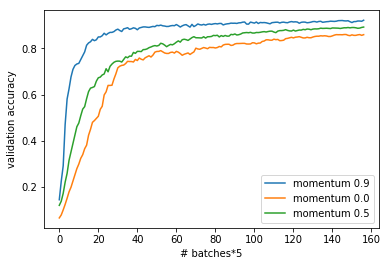

In [26]:
_, ax = plt.subplots()
ax.plot(valid_accs_1, label='momentum 0.9')
ax.plot(valid_accs_2, label='momentum 0.0')
ax.plot(valid_accs_3, label='momentum 0.5')
plt.xlabel('# batches*5')
plt.ylabel('validation accuracy')
ax.legend()